In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# CSV file paths function
file_path_1 = r'D:\Fake-news-detection\fake.csv'
file_path_2 = r'D:\Fake-news-detection\true.csv'
def load_data(file_path_1, file_path_2):
    """Load data from a CSV file."""
    if not os.path.exists(file_path_1):
        raise FileNotFoundError(f"The file {file_path_1} does not exist.")
    if not os.path.exists(file_path_2):
        raise FileNotFoundError(f"The file {file_path_2} does not exist.")
    fakedata = pd.read_csv(file_path_1)
    realdata = pd.read_csv(file_path_2)
    print(f"Data loaded successfully from {file_path_1} and {file_path_2}.")
    return fakedata, realdata

fakedata, realdata = load_data(file_path_1, file_path_2)

Data loaded successfully from D:\Fake-news-detection\fake.csv and D:\Fake-news-detection\true.csv.


In [3]:
#Data's shape (rowa and columns)
print("Fake news shape:", fakedata.shape)
print("True news shape:", realdata.shape)


Fake news shape: (23481, 4)
True news shape: (21417, 4)


In [4]:
# First 5 rows check karne ke liye
print("\nFake News Sample:")
print(fakedata.head())

print("\nTrue News Sample:")
print(realdata.head())


Fake News Sample:
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017  

True News Sample:
                                               title  \
0  As U.S. budget fight looms, Republicans fli

In [5]:
# Description of the datasets
print("\nFake News Description:")
print(fakedata.describe(include='all'))
print("\nTrue News Description:")
print(realdata.describe(include='all'))


Fake News Description:
                                                    title   text subject  \
count                                               23481  23481   23481   
unique                                              17903  17455       6   
top     MEDIA IGNORES Time That Bill Clinton FIRED His...           News   
freq                                                    6    626    9050   

                date  
count          23481  
unique          1681  
top     May 10, 2017  
freq              46  

True News Description:
                                                    title  \
count                                               21417   
unique                                              20826   
top     Factbox: Trump fills top jobs for his administ...   
freq                                                   14   

                                                     text       subject  \
count                                               21417         21417   


In [6]:
# Check for missing values
print("\nMissing values in Fake News dataset:")
print(fakedata.isnull().sum())
print("\nMissing values in True News dataset:")
print(realdata.isnull().sum())


Missing values in Fake News dataset:
title      0
text       0
subject    0
date       0
dtype: int64

Missing values in True News dataset:
title      0
text       0
subject    0
date       0
dtype: int64


In [7]:
# Fake dataset duplicates
dup_fake = fakedata[fakedata.duplicated()]
print("Fake.csv duplicates count:", dup_fake.shape[0])

# True dataset duplicates
dup_true = realdata[realdata.duplicated()]
print("True.csv duplicates count:", dup_true.shape[0])

print("\nSample duplicate rows from Fake dataset:")
print(dup_fake.head())

print("\nSample duplicate rows from True dataset:")
print(dup_true.head())

Fake.csv duplicates count: 3
True.csv duplicates count: 206

Sample duplicate rows from Fake dataset:
                                                   title  \
9942   HILLARY TWEETS MESSAGE In Defense Of DACA…OOPS...   
11446  FORMER DEMOCRAT WARNS Young Americans: “Rioter...   
14925  [VIDEO] #BlackLivesMatter Terrorists Storm Dar...   

                                                    text   subject  \
9942   No time to waste   we've got to fight with eve...  politics   
11446   Who is silencing political speech, physically...  politics   
14925  They were probably just looking for a  safe sp...  politics   

               date  
9942    Sep 9, 2017  
11446  Mar 10, 2017  
14925  Nov 16, 2015  

Sample duplicate rows from True dataset:
                                                 title  \
445  Senate tax bill stalls on deficit-focused 'tri...   
778  Trump warns 'rogue regime' North Korea of grav...   
892  Republicans unveil tax cut bill, but the hard ...   
896  Trump tap

In [8]:
# Remove duplicates
fakedata = fakedata.drop_duplicates()
realdata = realdata.drop_duplicates()
print("Duplicates removed.")

Duplicates removed.


In [9]:
print (fakedata.shape)
print (realdata.shape)

(23478, 4)
(21211, 4)


In [10]:
# Add labels to the datasets (1 for fake, 0 for true) "Also called as label encoding"
fakedata['label'] = 1
realdata['label'] = 0

In [11]:
# Combine the datasets
data = pd.concat([fakedata, realdata], ignore_index=True)
print("Datasets combined.")
print("Combined dataset shape:", data.shape)
print(data.head())

Datasets combined.
Combined dataset shape: (44689, 5)
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  label  
0  December 31, 2017      1  
1  December 31, 2017      1  
2  December 30, 2017      1  
3  December 29, 2017      1  
4  December 25, 2017      1  


In [12]:
# Shuffle the combined dataset
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
print("Combined dataset shuffled.")
print(data.head())
print(data['label'].value_counts())
# Check for missing values in the combined dataset
print("\nMissing values in combined dataset:")
print(data.isnull().sum())

Combined dataset shuffled.
                                               title  \
0  WOW! LEFTIST LIBRARIAN REJECTS Shipment Of Chi...   
1  Kenya opposition leader calls for calm in slum...   
2  Egypt rejects U.S. decision to move its embass...   
3  (AUDIO)NATION OF ISLAM LEADER FARRAKHAN: “WE W...   
4   Trump Rally Nearly Turns Into A Full-Blown Ra...   

                                                text    subject  \
0  A school librarian in Cambridge, Massachusetts...  left-news   
1  NAIROBI (Reuters) - Kenyan opposition leader R...  worldnews   
2  CAIRO (Reuters) - Egypt rejected the U.S. deci...  worldnews   
3  After a recent speech given by Minister Louis ...  left-news   
4  Tensions ran high outside of a campaign rally ...       News   

                date  label  
0       Sep 28, 2017      1  
1  October 29, 2017       0  
2  December 6, 2017       0  
3        May 8, 2015      1  
4     March 11, 2016      1  
label
1    23478
0    21211
Name: count, dtype: int64

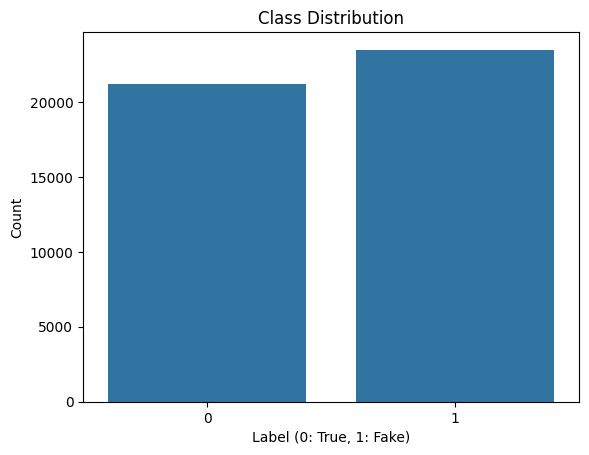

In [13]:
# Visualize the class distribution
import matplotlib.pyplot as plt
sns.countplot(x='label', data=data)
plt.title('Class Distribution')
plt.xlabel('Label (0: True, 1: Fake)')
plt.ylabel('Count')
plt.show()

TEXT PROCESSING

In [ ]:
'''Text Preprocessing Function
nltk.download('stopwords')

def text_processing(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)  # Remove all non-word characters
    text = re.sub(r'\s+', ' ', text)  # Remove multiple spaces
    text = re.sub(r'\d', ' ', text)  # Remove digits
    text = re.sub(r"https?://\S+|www\.\S+", ' ', text)  # Remove URLs
    text = re.sub(r'<.*?>', ' ', text)  # Remove HTML tags
    text = text.strip()  # Remove leading and trailing spaces
    tokens = text.split()
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)
data['text'] = data['text'].apply(text_processing)
print("Text preprocessing completed.")
print(data.head())'''

In [15]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))  # load once
lemmatizer = WordNetLemmatizer()              # create once

def text_processing(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\d', ' ', text)
    text = re.sub(r"https?://\S+|www\.\S+", ' ', text)
    text = re.sub(r'<.*?>', ' ', text)
    text = text.strip()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data['text'] = data['text'].apply(text_processing)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anamika\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Anamika\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
print("Text preprocessing completed.")
print(data.head())

Text preprocessing completed.
                                               title  \
0  WOW! LEFTIST LIBRARIAN REJECTS Shipment Of Chi...   
1  Kenya opposition leader calls for calm in slum...   
2  Egypt rejects U.S. decision to move its embass...   
3  (AUDIO)NATION OF ISLAM LEADER FARRAKHAN: “WE W...   
4   Trump Rally Nearly Turns Into A Full-Blown Ra...   

                                                text    subject  \
0  school librarian cambridge massachusetts rejec...  left-news   
1  nairobi reuters kenyan opposition leader raila...  worldnews   
2  cairo reuters egypt rejected u decision move e...  worldnews   
3  recent speech given minister louis farrakhan t...  left-news   
4  tension ran high outside campaign rally donald...       News   

                date  label  
0       Sep 28, 2017      1  
1  October 29, 2017       0  
2  December 6, 2017       0  
3        May 8, 2015      1  
4     March 11, 2016      1  


In [17]:
output_file_path = r'D:\Fake-news-detection\preprocessed_data.csv'
data.to_csv(output_file_path, index=False)
print(f"Preprocessed data saved to {output_file_path}.")

Preprocessed data saved to D:\Fake-news-detection\preprocessed_data.csv.
